# Simulating pore with varying tether length and sequences

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
(60.57 - 39.43)*0.8518

18.007052

In [2]:
'''
Initialise functions for plotting and processing data
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video


#centre of barrel
xc = (60.57 + 39.43)/2
yc = 50
zc = 69.96
lengthToNm = 0.8518 
timeTons   = 3.03e-3
barHeight = 61.05

connShift = [0, 168, 180, 220]


def getPoreNt(teth_len, numConn = 0):
    scaf_start = 0 + connShift[numConn]
    scaf_end   = 593-40 + teth_len*2
    return np.arange(teth_len + scaf_start, scaf_end - teth_len)
    
    
def getTopNt(teth_len, numConn = 0):
    return teth_len + connShift[numConn]
    
def getMidNt(teth_len, numConn = 0):
    return teth_len + 44 + connShift[numConn]

def getBotNt(teth_len, numConn = 0):
    return teth_len + 89 + connShift[numConn]
    
    
def RMS(x, y, z):
    #takes a vector (e.g. velocity) broken into components x,y,z and returns the RMS value
    return np.sqrt(x**2 + y**2 + z**2)


def getPosition(data, nt, pos, vel, rot):
    #takes data and returns position in nm relative to centre of barrel
    xpos = data[:,0 + 3*nt*(pos + vel + rot)] 
    ypos = data[:,1 + 3*nt*(pos + vel + rot)] 
    zpos = data[:,2 + 3*nt*(pos + vel + rot)] 
    xpos = (xpos - xc)*lengthToNm
    ypos = (ypos - yc)*lengthToNm
    zpos = (zpos - zc)*lengthToNm
    
    if np.ndim(xpos) == 2:
        posV = np.zeros([3, np.shape(xpos)[0], np.shape(xpos)[1]])
        posV[0,:,:] = xpos
        posV[1,:,:] = ypos
        posV[2,:,:] = zpos         
    else:
        posV = np.zeros([3, np.shape(xpos)[0]])
        posV[0,:] = xpos
        posV[1,:] = ypos
        posV[2,:] = zpos 

    return posV #np.array([xpos, ypos, zpos])

def getVelocity(data, nt, pos, vel, rot):
    #takes data and returns velocity in nm/ns relative to centre of barrel
    xvel = data[:,3 + 3*nt*(pos + vel + rot)] 
    yvel = data[:,4 + 3*nt*(pos + vel + rot)] 
    zvel = data[:,5 + 3*nt*(pos + vel + rot)] 
    xvel = xvel*lengthToNm/timeTons
    yvel = yvel*lengthToNm/timeTons
    zvel = zvel*lengthToNm/timeTons
    return [xvel, yvel, zvel]


def getAngularV(data, nt, pos, vel, rot):
    #takes data and returns angular velocity in 1/ns relative to centre of barrel
    xrot = data[:,6 + 3*nt*(pos + vel + rot)] 
    yrot = data[:,7 + 3*nt*(pos + vel + rot)] 
    zrot = data[:,8 + 3*nt*(pos + vel + rot)] 
    xrot = xrot/timeTons/np.pi*180
    yrot = yrot/timeTons/np.pi*180
    zrot = zrot/timeTons/np.pi*180
    return [xrot, yrot, zrot]


def takeMean(Vec):
    if type(Vec) == list:
        sz = len(Vec)
    else:
        sz = np.shape(Vec)[0]
    out = []
    #given a list takes the mean along each coordinate
    for i in range(sz):
        out.append(np.mean(Vec[i],1))
    return out


def takeMin(Vec):
    if type(Vec) == list:
        sz = len(Vec)
    else:
        sz = np.shape(Vec)[0]  
    out = []
    for i in range(sz):
        out.append(np.array(Vec[i]).min(1))
    return out
    
    
    
    
def takeMax(Vec): 
    if type(Vec) == list:
        sz = len(Vec)
    else:
        sz = np.shape(Vec)[0]
    out = []
    for i in range(sz):
        out.append(np.array(Vec[i]).max(1))
    return out

def cartToCyl(x,y,z):
    #converts Cartesian coords to cylindrical coordinates in degrees
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(posV[1], posV[0])/np.pi*180
    return [r, theta, z]


def plotPositionHist(posV, pType = 'z', title = None, vline = None, legend = []):
    '''
    plots the histogram of a spatial or angular coordinate
    posV is the position vector
    pType = 'x', 'y', 'z', 't' (theta), 'r' (radial)
    '''   
    
    if type(posV) == list:
        posList = posV
    else:        
        posList = [posV]
 
    if len(legend) == 0:
        legend = list(pType*len(posList))

    plt.figure()
    plt.xlabel('Position (nm)')
    
    for i in range(len(posList)):
        posV = posList[i]
        if pType == 'x':
            pos = posV[0]
            plt.title('Histogram of location of pore - x-position')
        elif pType == 'y':
            pos = posV[1]
            plt.title('Histogram of location of pore - y-position')        
        elif pType == 'z':
            pos = posV[2]
            plt.title('Histogram of location of pore - z-position')
        elif pType == 'r':
            pos = np.sqrt(posV[0]**2 + posV[1]**2)
            plt.title('Histogram of location of pore - r-position')
            plt.xlabel('Radial distance from centre of pore (nm)')
        elif pType == 't':
            pos = np.arctan2(posV[1], posV[0])/np.pi*180     
            plt.title('Histogram of location of pore - angular distance of pore in barrel')
            plt.xlabel('Angular distance of pore in barrel (degrees)')

        plt.hist(pos, density = True, bins = int(np.sqrt(len(pos))), label = legend[i], histtype=u'step')

    if title is not None:
        plt.title(title)
    xmin, xmax, ymin, ymax = plt.axis()    
    if vline is not None:
        plt.vlines(vline, 0, ymax, 'k')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()
    
    
def plotRMSHist(Vec, pType = 'vel'):
    '''
    plots the histogram of a spatial or angular coordinate
    Vec is a vector: either position, velocity or angular velocity
    pType = 'pos', 'vel', 'rot'
    '''       
    RMSVec = RMS(Vec[0], Vec[1], Vec[2])
    plt.figure()
    plt.hist(RMSVec, density = True)
    plt.ylabel('Probability density')

    if pType == 'pos':
        plt.xlabel('Average root mean squared position (nm)')
        plt.title('Histogram of average root mean squared position')
    elif pType == 'vel':
        plt.xlabel('Average root mean squared velocity (nm/ns)')
        plt.title('Histogram of average root mean squared velocity')
    elif pType == 'rot':
        plt.xlabel('Average root mean squared angular velocity (degrees/ns)')
        plt.title('Histogram of average root mean squared angular velocity')
    plt.show()
 

def plotMeanStdPair(xval, Means, Stds, ylabel1 = '', ylabel2 = '', xlabel = 'Tether length (bp)', title = ''):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color='b')
    ax1.plot(xval, Means, 'bo')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color='r')  
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.plot(xval, Stds, 'rx')
    plt.title(title)
    fig.tight_layout() 
    plt.show()
    
#plot mean-standard deviation pair with error bars
def plotMeanStdEB(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[1]):
            plt.errorbar(xval, Means[:,i], Stds[:,i], fmt=shapes[i] + ':', label = legend[i])
    
    if hline is not None:
        plt.hlines(hline, xval[0], xval[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()    

    
#plot mean-standard deviation pair with error bars inverse
def plotMeanStdEBInverse(xval, Means, Stds, ylabel = '', xlabel = 'Tether length (bp)', title = '', legend = [], hline = None, vline = None):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    shapes = ['o', '^', 'D', '*', 's', 'p', 'h']
    if np.ndim(Means) == 1:
        plt.errorbar(xval, Means, Stds, fmt='bo:', label = legend[0])
    else:
        for i in range(np.shape(Means)[0]):
            plt.errorbar(legend, Means[i,:], Stds[i,:], fmt=shapes[i] + ':', label = xval[i])
    
    if hline is not None:
        plt.hlines(hline, legend[0], legend[-1], linestyles='dashed')
    
    xmin, xmax, ymin, ymax = plt.axis()
    if vline is not None:
        plt.vlines(vline, ymin, ymax, linestyles='dashed')

    plt.title(title)
    plt.legend()
    plt.show()        

In [4]:
'''
Loop over data
'''

N = 8
M = 5

s = 0

poreEnd = 43
topEnd  = 9

ave_z   = np.zeros([N,M])
ave_r   = np.zeros([N,M])
ave_th  = np.zeros([N,M])
std_z   = np.zeros([N,M])
std_r   = np.zeros([N,M])
std_th  = np.zeros([N,M])

ave_top_z   = np.zeros([N,M])
ave_top_r   = np.zeros([N,M])
ave_top_th  = np.zeros([N,M])
std_top_z   = np.zeros([N,M])
std_top_r   = np.zeros([N,M])
std_top_th  = np.zeros([N,M])

ave_mid_z   = np.zeros([N,M])
ave_mid_r   = np.zeros([N,M])
ave_mid_th  = np.zeros([N,M])
std_mid_z   = np.zeros([N,M])
std_mid_r   = np.zeros([N,M])
std_mid_th  = np.zeros([N,M])

ave_bot_z   = np.zeros([N,M])
ave_bot_r   = np.zeros([N,M])
ave_bot_th  = np.zeros([N,M])
std_bot_z   = np.zeros([N,M])
std_bot_r   = np.zeros([N,M])
std_bot_th  = np.zeros([N,M])

ave_min_z   = np.zeros([N,M])
ave_min_r   = np.zeros([N,M])
ave_min_th  = np.zeros([N,M])
std_min_z   = np.zeros([N,M])
std_min_r   = np.zeros([N,M])
std_min_th  = np.zeros([N,M])

ave_max_z   = np.zeros([N,M])
ave_max_r   = np.zeros([N,M])
ave_max_th  = np.zeros([N,M])
std_max_z   = np.zeros([N,M])
std_max_r   = np.zeros([N,M])
std_max_th  = np.zeros([N,M])

ave_bonds   = np.zeros([N,M])
std_bonds   = np.zeros([N,M])
max_bonds   = np.zeros([N,M])
min_bonds   = np.zeros([N,M])
end_bonds   = np.zeros([N,M])


FracOut = np.zeros([N, M])
FracTop = np.zeros([N, M])

minBonds = 0 #[495, 495 + 60, 495 + 11*15, 495 + 84*2, 495 + 84*2] #84*2 is the cinch length

teth_len = 120
conns = [0,0,0,0,0,0,0,0]

for c in range(N):
    for m in range(M):
        print('Now processing : cinch' + str(c) + ', seed: ' + str(m))
        data = np.genfromtxt('cinch' + str(c) + '/outposMD' + str(m) + '.dat')

        #nucleotide to track
        nt = getPoreNt(teth_len, numConn = conns[c])

        #Get mean positions
        posV = takeMean(getPosition(data, nt, 1, 0, 0))

        #if pore is in opposite orientation
        if np.mean(posV[2]) > 0:
            zsign = -1
        else:
            zsign = 1

        ave_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_z[c,m]   = np.std(posV[2][s:-1])
        std_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get top positions
        posV = getPosition(data, getTopNt(teth_len, numConn = conns[c]), 1, 0, 0)
        ave_top_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_top_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_top_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_top_z[c,m]   = np.std(posV[2][s:-1])
        std_top_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_top_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get middle positions
        posV = getPosition(data, getMidNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_mid_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_mid_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_mid_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_mid_z[c,m]   = np.std(posV[2][s:-1])
        std_mid_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_mid_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #Get bottom positions
        posV = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)              
        ave_bot_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_bot_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_bot_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_bot_z[c,m]   = np.std(posV[2][s:-1])
        std_bot_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_bot_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))


        #Get minimum positions
        posV = takeMin(getPosition(data, nt, 1, 0, 0))  
        posV1 = posV.copy()
        ave_min_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_min_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_min_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_min_z[c,m]   = np.std(posV[2][s:-1])
        std_min_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_min_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        
        #Get maximum positions
        posV = takeMax(getPosition(data, nt, 1, 0, 0))            
        ave_max_z[c,m]   = np.mean(posV[2][s:-1])*zsign
        ave_max_r[c,m]   = np.mean(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        ave_max_th[c,m]  = np.mean(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))
        std_max_z[c,m]   = np.std(posV[2][s:-1])
        std_max_r[c,m]   = np.std(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[0])
        std_max_th[c,m]  = np.std(abs(cartToCyl(posV[0][s:-1],posV[1][s:-1],posV[2][s:-1])[1]))

        #fraction of time outside the pore
        FracOut[c,m] = sum(((posV1[2][s:-1][i] < -poreEnd) | (posV[2][s:-1][i] >  topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])      
        FracTop[c,m] = sum(((posV[2][s:-1][i] >  poreEnd)  | (posV1[2][s:-1][i] < -topEnd))  for i in range(len(posV[2][s:-1])))/len(posV[2][s:-1])

        #number of bonds
        bonds = np.genfromtxt('cinch' + str(c) + '/numbondsMD' + str(m) + '.txt')    
        bonds = bonds - minBonds
        bonds = bonds.clip(min=0)
        ave_bonds[c,m]   = np.mean(bonds)
        std_bonds[c,m]   = np.std(bonds)
        max_bonds[c,m]   = np.max(bonds)
        min_bonds[c,m]   = np.min(bonds)        
        end_bonds[c,m]   = bonds[-1]
    

        
print('Finished processing')

Now processing : cinch0, seed: 0
Now processing : cinch0, seed: 1
Now processing : cinch0, seed: 2
Now processing : cinch0, seed: 3
Now processing : cinch0, seed: 4
Now processing : cinch1, seed: 0
Now processing : cinch1, seed: 1
Now processing : cinch1, seed: 2
Now processing : cinch1, seed: 3
Now processing : cinch1, seed: 4
Now processing : cinch2, seed: 0
Now processing : cinch2, seed: 1
Now processing : cinch2, seed: 2
Now processing : cinch2, seed: 3
Now processing : cinch2, seed: 4
Now processing : cinch3, seed: 0
Now processing : cinch3, seed: 1
Now processing : cinch3, seed: 2
Now processing : cinch3, seed: 3
Now processing : cinch3, seed: 4
Now processing : cinch4, seed: 0
Now processing : cinch4, seed: 1
Now processing : cinch4, seed: 2
Now processing : cinch4, seed: 3
Now processing : cinch4, seed: 4
Now processing : cinch5, seed: 0
Now processing : cinch5, seed: 1
Now processing : cinch5, seed: 2
Now processing : cinch5, seed: 3
Now processing : cinch5, seed: 4
Now proces

In [5]:
FracOut

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.88362069, 0.25570776, 0.98190045, 0.96035242, 0.53603604]])

In [22]:
FracOut

array([[0.        , 0.00325733, 0.00704225, 0.00346021, 0.00371747],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.35294118, 0.        , 0.99145299, 0.76818182, 0.69911504]])

In [6]:
max_bonds

array([[551., 552., 557., 559., 560.],
       [683., 680., 678., 682., 680.],
       [680., 682., 678., 680., 679.],
       [617., 617., 619., 617., 620.],
       [685., 681., 683., 685., 684.],
       [614., 613., 613., 619., 618.],
       [691., 691., 685., 691., 690.],
       [703., 706., 702., 702., 709.]])

In [8]:
ave_min_z

array([[-31.76786462, -30.69812373, -29.88153636, -31.07146513,
        -30.06797352],
       [-29.15462921, -29.0183561 , -29.00064689, -29.28793366,
        -29.2467539 ],
       [-29.31290891, -29.5410158 , -29.35753225, -29.06797577,
        -29.57306343],
       [-30.45354813, -29.64991579, -30.54375568, -30.39601889,
        -30.64201059],
       [-28.64514849, -28.54052235, -28.27322849, -28.49488106,
        -28.43394487],
       [-30.70588016, -30.38938292, -30.4203767 , -30.39446111,
        -29.95592864],
       [-35.47593036, -34.98166122, -35.82661925, -35.52263291,
        -36.07133319],
       [-51.59180465, -35.5100985 , -54.78922939, -55.58559397,
        -42.29193397]])

In [9]:
#save results to hdf5 file
import h5py

saveName = 'resultsSummary.hdf5'

with h5py.File(saveName, "a") as f:
    #f.create_dataset("teth_lens", data=np.array(teth_lens))
    f.create_dataset("ave_z", data=ave_z)
    f.create_dataset("ave_r", data=ave_r)
    f.create_dataset("ave_th", data=ave_th)
    f.create_dataset("std_z", data=std_z)
    f.create_dataset("std_r", data=std_r)
    f.create_dataset("std_th", data=std_th)
    f.create_dataset("ave_top_z", data=ave_top_z)
    f.create_dataset("ave_top_r", data=ave_top_r)
    f.create_dataset("ave_top_th", data=ave_top_th)
    f.create_dataset("std_top_z", data=std_top_z)
    f.create_dataset("std_top_r", data=std_top_r)
    f.create_dataset("std_top_th", data=std_top_th)
    f.create_dataset("ave_mid_z", data=ave_mid_z)
    f.create_dataset("ave_mid_r", data=ave_mid_r)
    f.create_dataset("ave_mid_th", data=ave_mid_th)
    f.create_dataset("std_mid_z", data=std_mid_z)
    f.create_dataset("std_mid_r", data=std_mid_r)
    f.create_dataset("std_mid_th", data=std_mid_th)
    f.create_dataset("ave_bot_z", data=ave_bot_z)
    f.create_dataset("ave_bot_r", data=ave_bot_r)
    f.create_dataset("ave_bot_th", data=ave_bot_th)
    f.create_dataset("std_bot_z", data=std_bot_z)
    f.create_dataset("std_bot_r", data=std_bot_r)
    f.create_dataset("std_bot_th", data=std_bot_th)
    f.create_dataset("ave_min_z", data=ave_min_z)
    f.create_dataset("ave_min_r", data=ave_min_r)
    f.create_dataset("ave_min_th", data=ave_min_th)
    f.create_dataset("std_min_z", data=std_min_z)
    f.create_dataset("std_min_r", data=std_min_r)
    f.create_dataset("std_min_th", data=std_min_th)    
    f.create_dataset("FracOut", data=FracOut) 

In [9]:
i = 7
print(FracOut[i],ave_top_z[i],',',std_top_z[i], ',', ave_top_r[i],',',std_top_r[i],',',ave_mid_z[i],',',std_mid_z[i],',', ave_mid_r[i],',',std_mid_r[i],',',ave_bot_z[i],',',std_bot_z[i],',', ave_bot_r[i],',',std_bot_r[i],',',ave_z[i],',',std_z[i],',', ave_r[i],',',std_r[i],',',ave_min_z[i],',',std_min_z[i],',', ave_min_r[i],',',std_min_r[i])

[0.88362069 0.25570776 0.98190045 0.96035242 0.53603604] [ 1.55315618 -0.96823348  1.64802078  1.64299544 -0.14666893] , [2.25963414 2.39162687 1.22752923 1.89316206 2.55119829] , [6.85336181 7.23674276 7.47878561 7.06090533 7.45787778] , [1.37018563 1.29957059 1.01929585 1.15716038 1.11860232] , [-17.74652572  -1.54043673 -20.78033754 -21.76582835  -8.2334392 ] , [ 7.28938088 11.55480469  3.67600362  4.77122597 13.85611471] , [3.73082641 3.44783347 3.72051292 3.5854718  3.34754645] , [1.61521721 1.7719322  1.52744009 1.55673838 1.67030322] , [ -7.98725738   5.68411981 -10.53180497 -10.02719511  -0.26896411] , [ 6.71543853  9.5344196   3.25077874  3.81734566 11.22211833] , [4.47171638 5.486184   4.96008781 4.72487782 5.71739933] , [2.12193911 2.23244429 1.85095153 1.96783337 2.03959749] , [-32.14014128 -16.90593634 -35.04148822 -35.77179169 -23.25791318] , [ 6.80469637 10.8819524   3.38350872  4.46344825 12.94007799] , [2.64365605 2.19282443 2.85048821 2.67403485 2.3747732 ] , [1.17357

In [5]:
#No Standard deviation
for i in range(8):
    print(np.mean(FracOut[i]), ',', np.mean(ave_top_z[i]), ',',  np.mean(std_top_z[i]), ',', np.mean(ave_top_r[i]),',', np.mean(std_top_r[i]),',',np.mean(ave_mid_z[i]),',', np.mean(std_mid_z[i]),',',np.mean(ave_mid_r[i]),',',np.mean(std_mid_r[i]),',',np.mean(ave_bot_z[i]),',', np.mean(std_bot_z[i]),',',np.mean(ave_bot_r[i]),',',np.mean(std_bot_r[i]),',',np.mean(ave_min_z[i]),',',np.mean(std_min_z[i]),',', np.mean(ave_min_r[i]),',',np.mean(std_min_r[i]),',',np.mean(ave_max_z[i]),',',np.mean(std_max_z[i]),',',np.mean(ave_max_r[i]),',',np.mean(std_max_r[i]),',',np.mean(ave_bonds[i]),',',np.mean(std_bonds[i]),',',np.min(min_bonds[i]),',',np.max(max_bonds[i]))

0.0 , -2.3212859214797446 , 3.116337694148869 , 3.4551294480601045 , 1.5607804539711128 , -16.459176776523584 , 3.0919496285688584 , 3.021372953899524 , 1.4455035341414337 , -29.82304641305321 , 3.190215635000911 , 4.630958120980637 , 2.030706509926606 , -30.697392670860403 , 3.086878425656019 , 7.171990486756329 , 1.9244927375447318 , -0.4697554906649855 , 3.0662782078804423 , 8.27648615613119 , 1.6523403773672516 , 540.9891852108981 , 7.8626150085265705 , 504.0 , 560.0
0.0 , -1.1501249126980375 , 1.078403427882449 , 4.589788455006856 , 1.2128607702194505 , -14.724800236645105 , 1.0917237075744275 , 2.488888340223577 , 1.1534780176402641 , -27.94667083764933 , 1.3405935334940884 , 4.91384541377317 , 2.0602314138097464 , -29.141663954185578 , 1.143832439597266 , 7.287058055366822 , 1.7122248693952755 , 0.813910573015303 , 1.185883538400509 , 9.078880141732638 , 1.1992319261509805 , 671.6162612809668 , 3.9158719364480605 , 655.0 , 683.0
0.0 , -1.264053048059226 , 1.1716445828349173 , 4.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

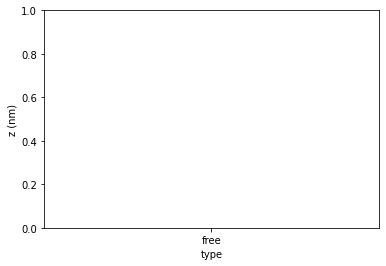

In [8]:
'''
Comparison between the different pores
'''

teth_lens = [teth_len]
seqNames = ['free','42x2,s4','42x2,s6','46,s10','42x2,s0','42,s42','42,z42','z42x2']
types = ['top', 'mid', 'bot', 'mean', 'min']
ave_zs    = np.array([ave_top_z[:], ave_mid_z[:], ave_bot_z[:], ave_z[:], ave_min_z[:]])
std_zs    = np.array([std_top_z[:], std_mid_z[:], std_bot_z[:], std_z[:], std_min_z[:]])
ave_rs    = np.array([ave_top_r[:], ave_mid_r[:], ave_bot_r[:], ave_r[:], ave_min_r[:]])
std_rs    = np.array([std_top_r[:], std_mid_r[:], std_bot_r[:], std_r[:], std_min_r[:]])

plotMeanStdEBInverse(types, ave_zs, std_zs, ylabel = 'z (nm)', title = 'Vertical position in barrel', legend = seqNames, xlabel = 'type', hline = -43)
plotMeanStdEBInverse(types, ave_rs, std_rs, ylabel = 'r (nm)', title = 'Radial position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_zs, std_zs*0, ylabel = 'std(z) (nm)', title = 'Std Vertical position in barrel', legend = seqNames, xlabel = 'type')
plotMeanStdEBInverse(types, std_rs, std_rs*0, ylabel = 'std(r) (nm)', title = 'Std Radial position in barrel', legend = seqNames, xlabel = 'type')

plt.figure()
plt.plot(seqNames, FracOut, 'o:')
plt.ylabel('Outside barrel (%)')
plt.title('Fraction of time outside barrel')
plt.show()
#plotMeanStdEBInverse(teth_lens, 100*FracOut, 0*FracOut, ylabel = 'Outside barrel (%)', title = 'Fraction of time outside barrel', legend = seqNames, xlabel = 'type')
#plotMeanStdEBInverse(teth_lens, ave_bonds, std_bonds, ylabel = 'Number of tether bonds', title = 'Bonding on tether', legend = seqNames, xlabel = 'type')

In [15]:
c = 0
data = np.genfromtxt('cinch' + str(c) + '/outposMD1.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
free = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

c = 5
data = np.genfromtxt('cinch' + str(c) + '/outposMD1.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
cin1 = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

c = 4
data = np.genfromtxt('cinch' + str(c) + '/outposMD1.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
cin2 = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

c = 6
data = np.genfromtxt('cinch' + str(c) + '/outposMD1.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
cin3 = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

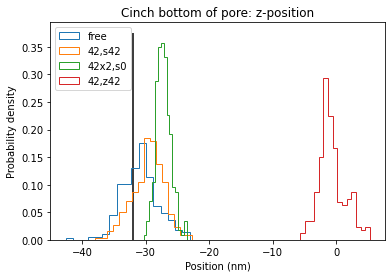

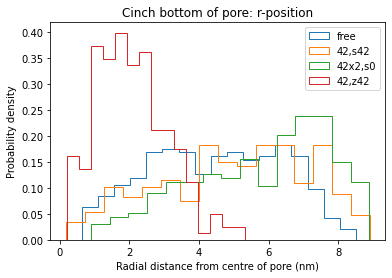

In [6]:
plotPositionHist([free, cin1, cin2, cin3], 'z', title = 'Cinch bottom of pore: z-position', vline = -32, legend = ['free','42,s42','42x2,s0','42,z42'])

plotPositionHist([free, cin1, cin2, cin3], 'r', title = 'Cinch bottom of pore: r-position', legend = ['free','42,s42','42x2,s0','42,z42'])

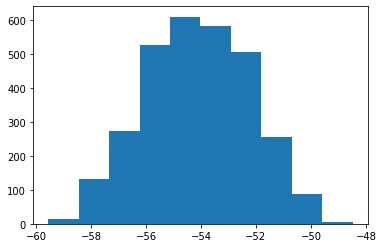

In [9]:
plt.hist(free[2][1:2000])
plt.show()

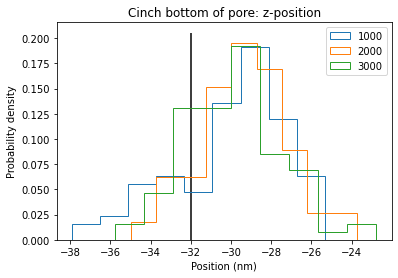

In [18]:
plotPositionHist([cin1[:,0:90], cin1[:,90:180], cin1[:,180:]], 'z', title = 'Cinch bottom of pore: z-position', vline = -32, legend = ['1000','2000', '3000'])

In [19]:
rMean = [np.mean(cin4[0:i+2]) for i in range(len(cin4))]

(3, 4868)

In [13]:
np.shape(cin1)

(3, 270)

In [9]:
c = 0
data = np.genfromtxt('cinch' + str(c) + '/outposMD4.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
mc = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

data = np.genfromtxt('cinch' + str(c) + '/outposMD1.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
md = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

data = np.genfromtxt('cinch' + str(c) + '/outposMD3.dat')
nt = getPoreNt(teth_len, numConn = conns[c])
vm = getPosition(data, getBotNt(teth_len, numConn = conns[c]), 1, 0, 0)

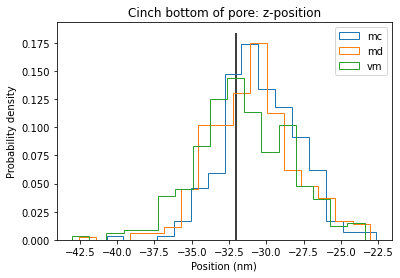

In [10]:
plotPositionHist([mc[:,0:], md[:,0:], vm[:,0:]], 'z', title = 'Cinch bottom of pore: z-position', vline = -32, legend = ['mc','md','vm'])

In [3]:
np.shape(vm[:,0:5])

NameError: name 'vm' is not defined